In [ ]:
# %pip install -q mlflow torchmetrics torchinfo

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import Accuracy
from torchvision import datasets
from torchvision.transforms import ToTensor

import mlflow

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
print(f"Image size: {training_data[0][0].shape}")
print(f"Size of training dataset: {len(training_data)}")
print(f"Size of test dataset: {len(test_data)}")

Image size: torch.Size([1, 28, 28])
Size of training dataset: 60000
Size of test dataset: 10000


In [ ]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.LazyLinear(10),  # 10 classes in total.
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
mlflow.set_tracking_uri("http://localhost:5000")

In [ ]:
mlflow.set_experiment("/mlflow-pytorch-quickstart")

2025/02/25 21:31:15 INFO mlflow.tracking.fluent: Experiment with name '/mlflow-pytorch-quickstart' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/501040217236460296', creation_time=1740486675281, experiment_id='501040217236460296', last_update_time=1740486675281, lifecycle_stage='active', name='/mlflow-pytorch-quickstart', tags={}>

In [ ]:
# Get cpu or gpu for training.
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def train(dataloader, model, loss_fn, metrics_fn, optimizer, epoch):
    """Train the model on a single pass of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the training data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        loss_fn: a callable, the loss function.
        metrics_fn: a callable, the metrics function.
        optimizer: an instance of `torch.optim.Optimizer`, the optimizer used for training.
        epoch: an integer, the current epoch number.
    """
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        accuracy = metrics_fn(pred, y)

        # Backpropagation.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch
            step = batch // 100 * (epoch + 1)
            mlflow.log_metric("loss", f"{loss:2f}", step=step)
            mlflow.log_metric("accuracy", f"{accuracy:2f}", step=step)
            print(f"loss: {loss:2f} accuracy: {accuracy:2f} [{current} / {len(dataloader)}]")

In [ ]:
def evaluate(dataloader, model, loss_fn, metrics_fn, epoch):
    """Evaluate the model on a single pass of the dataloader.

    Args:
        dataloader: an instance of `torch.utils.data.DataLoader`, containing the eval data.
        model: an instance of `torch.nn.Module`, the model to be trained.
        loss_fn: a callable, the loss function.
        metrics_fn: a callable, the metrics function.
        epoch: an integer, the current epoch number.
    """
    num_batches = len(dataloader)
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            eval_loss += loss_fn(pred, y).item()
            eval_accuracy += metrics_fn(pred, y)

    eval_loss /= num_batches
    eval_accuracy /= num_batches
    mlflow.log_metric("eval_loss", f"{eval_loss:2f}", step=epoch)
    mlflow.log_metric("eval_accuracy", f"{eval_accuracy:2f}", step=epoch)

    print(f"Eval metrics: \nAccuracy: {eval_accuracy:.2f}, Avg loss: {eval_loss:2f} \n")

In [ ]:
epochs = 3
loss_fn = nn.CrossEntropyLoss()
metric_fn = Accuracy(task="multiclass", num_classes=10).to(device)
model = ImageClassifier().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
with mlflow.start_run() as run:
    params = {
        "epochs": epochs,
        "learning_rate": 1e-3,
        "batch_size": 64,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "SGD",
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("model_summary.txt", "w") as f:
        f.write(str(summary(model)))
    mlflow.log_artifact("model_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, metric_fn, optimizer, epoch=t)
        evaluate(test_dataloader, model, loss_fn, metric_fn, epoch=0)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model, "model")

Epoch 1
-------------------------------
loss: 2.306931 accuracy: 0.078125 [0 / 938]
loss: 2.273428 accuracy: 0.281250 [100 / 938]
loss: 2.192749 accuracy: 0.546875 [200 / 938]
loss: 2.109706 accuracy: 0.515625 [300 / 938]
loss: 1.844982 accuracy: 0.625000 [400 / 938]
loss: 1.452427 accuracy: 0.687500 [500 / 938]
loss: 1.172778 accuracy: 0.703125 [600 / 938]
loss: 0.922216 accuracy: 0.765625 [700 / 938]
loss: 0.908924 accuracy: 0.734375 [800 / 938]
loss: 0.865114 accuracy: 0.781250 [900 / 938]
Eval metrics: 
Accuracy: 0.73, Avg loss: 0.788870 

Epoch 2
-------------------------------
loss: 0.759794 accuracy: 0.781250 [0 / 938]
loss: 0.838669 accuracy: 0.734375 [100 / 938]
loss: 0.534164 accuracy: 0.812500 [200 / 938]
loss: 0.821866 accuracy: 0.703125 [300 / 938]
loss: 0.702150 accuracy: 0.703125 [400 / 938]
loss: 0.689902 accuracy: 0.765625 [500 / 938]
loss: 0.734743 accuracy: 0.703125 [600 / 938]
loss: 0.646700 accuracy: 0.765625 [700 / 938]
loss: 0.692729 accuracy: 0.718750 [800 / 938

2025/02/25 21:33:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run stately-hog-877 at: http://localhost:5000/#/experiments/501040217236460296/runs/3cec7ccd89ef45daa14a82836a503709
🧪 View experiment at: http://localhost:5000/#/experiments/501040217236460296


In [ ]:
logged_model = f"runs:/{run.info.run_id}/model"
logged_model

'runs:/3cec7ccd89ef45daa14a82836a503709/model'

In [ ]:
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.pytorch
  run_id: 3cec7ccd89ef45daa14a82836a503709

In [ ]:
outputs = loaded_model.predict(training_data[0][0][None, :].numpy())

In [ ]:
outputs.shape

(1, 10)

Predicted: 9
Truth: 9


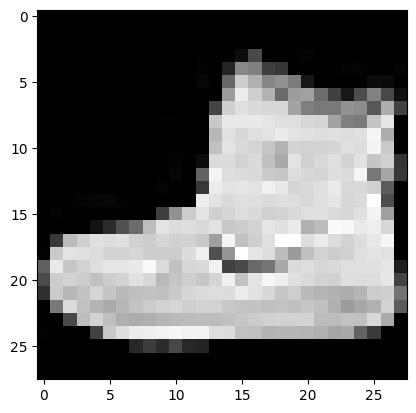

In [ ]:
import matplotlib.pyplot as plt
pred = outputs.argmax()
print(f"Predicted: {pred}")
print(f"Truth: {training_data[0][1]}")
plt.imshow(training_data[0][0][None, :].numpy().squeeze(), cmap="gray")
plt.show()